# Task 1

## Objectives

### Images Used:  
  1. *9343 AM*  
  2. *10905 JL*  
  3. *43590 AM*  

### Noise Reduction Techniques
  Guassian Filter   


### Edge Detectors Applied
  1. Sobel  
  2. Prewitt  
  3. Kirsch  
  4. Robinson  
  5. Gaussian  

### Discussion Points 
  - Analyze the effectiveness of each edge detection technique on the three provided images using F1 score.
  - Compare the results and discuss the impact of noise reduction on edge detection quality.


In [1]:
# Importing necessary libraries
import skimage
from skimage.color import rgb2gray

import scipy
import scipy.signal

from matplotlib import pyplot as plt

import numpy as np

import cv2

from sklearn.metrics import f1_score

from utils import display_original_and_gt, display_single, display_filtered_edge_results

### Constants

In [2]:
# Loading images to process and their ground truth.
image_names = ['9343 AM', '10905 JL', '43590 AM']


edge_detectors = ['sobel', 'prewitt', 'kirsch',
                  'robinson', 'gaussian']  # List of edge detectors
# Disctionary of kernels
kernels = {
    'sobel': {
        'x': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
        'y': np.array([[-1, -2, -1], [0,  0,  0], [1,  2,  1]])
    },
    'prewitt': {
        'x': np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]),
        'y': np.array([[1,  1,  1],[0,  0,  0],[-1, -1, -1]])
    },
    'kirsch': {
        'x': np.array([[3, 3, -5],[3, 0, -5], [3, 3, -5]]),
        'y': np.array([[3,  3,  3],[3,  0,  3],[-5, -5, -5]])
    },
    'robinson': {
        'x': np.array([[1,  1, -1],[1, -2, -1],[1,  1, -1]]),
        'y': np.array([[1,  1,  1],[1, -2,  1], [-1, -1, -1]])
    },
    'gaussian': {
        'x': np.array([[-1, -2,  0,  2,  1], [-4, -8,  0,  8,  4],[-6, -12, 0, 12, 6],
            [-4, -8,  0,  8,  4],[-1, -2,  0,  2,  1]]),
        'y': np.array([[-1, -4, -6, -4, -1],[-2, -8, -12, -8, -2],[0,  0,   0,  0,  0],
            [2,  8,  12,  8,  2],[1,  4,   6,  4,  1]])
    },
}

gaussian_filter = np.array([
    [1,  4,  7,  4,  1],
    [4, 16, 26, 16,  4],
    [7, 26, 41, 26,  7],
    [4, 16, 26, 16,  4],
    [1,  4,  7,  4,  1]
], dtype=np.float32)

# Normalize with sum = 273
gaussian_filter /= 273

# Dictionary to store edge results for and gaussian filtered images
edge_results = {
    "gaussian": {detector: [] for detector in kernels.keys()},
}

### Reading the images and the ground truth

In [3]:
images = []  # List for original image
ground_truths = []  # List for ground truth images
for image_name in image_names:
    print(f'{image_name} ')
    image = skimage.io.imread(f'Data 06 30213/cells/{image_name}.bmp')
    images.append(image)

    ground_truth = skimage.io.imread(
        f'Data 06 30213/cells/{image_name} Edges.bmp')
    ground_truths.append(ground_truth)

9343 AM 
10905 JL 
43590 AM 


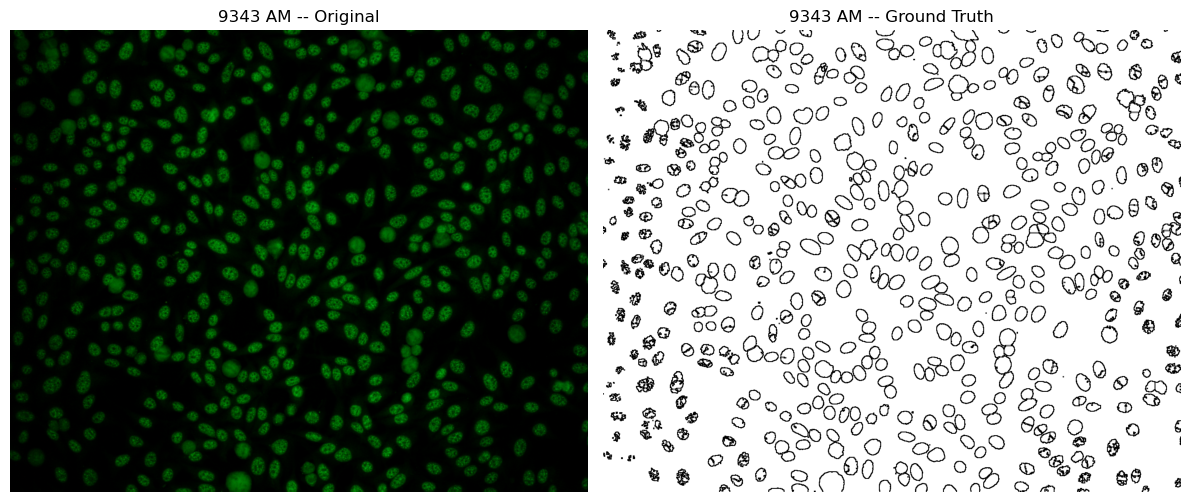

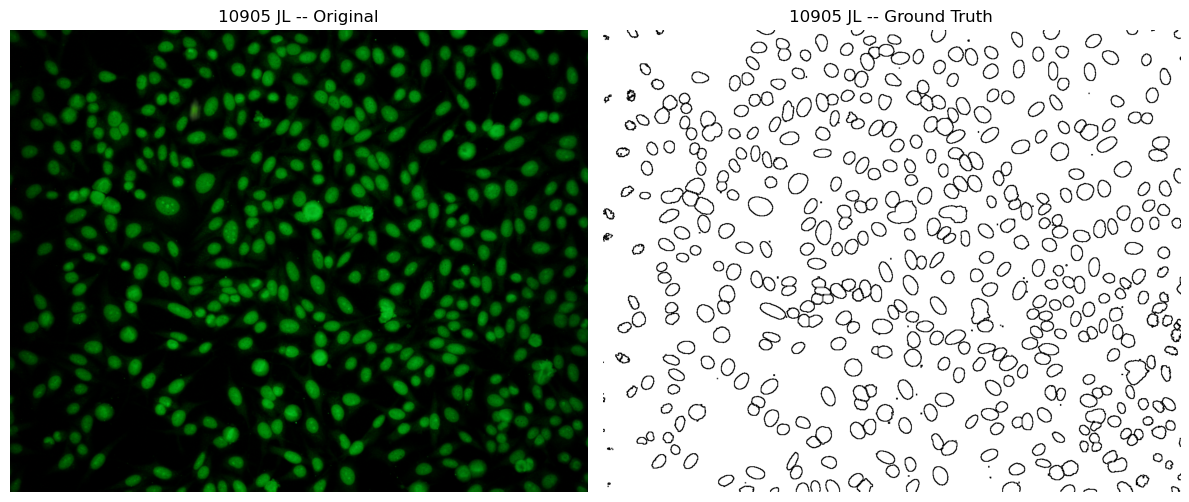

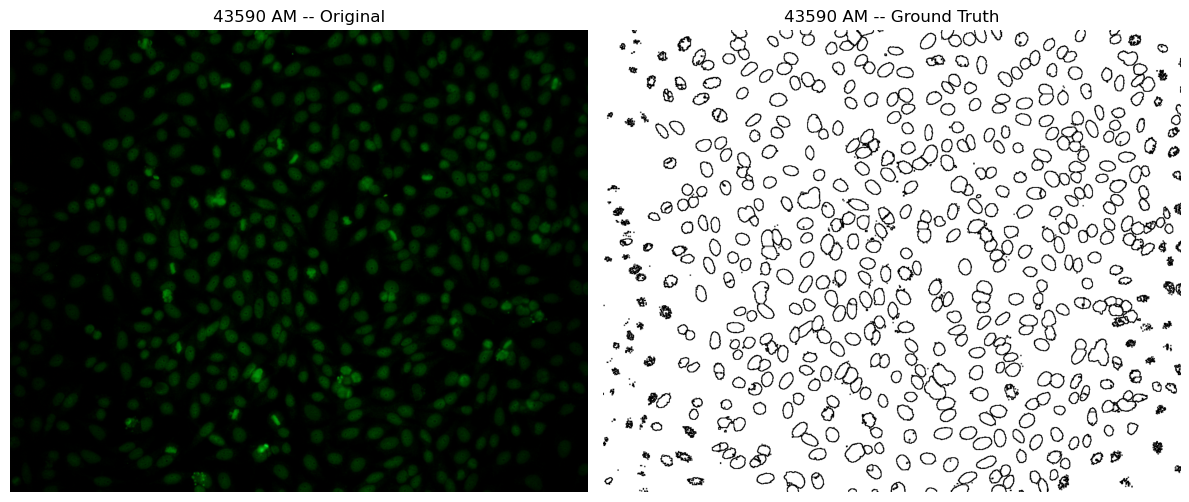

In [4]:
for i in range(len(images)):
    display_original_and_gt(images[i], ground_truths[i], image_names[i])

### Grayscaling

In [5]:
grayscale_images = []  # List for original image after GRAYSCALING
for i, image in enumerate(images):
    grayscale_image = rgb2gray(image)
    grayscale_images.append(grayscale_image)

### Noise Reduction

In [6]:
def remove_noise(image, filter):
    filtered_image = scipy.signal.convolve2d(
        image, filter, mode='same', boundary='symm')

    # Normalize the result to range 0-1
    normalized_image = (filtered_image - filtered_image.min()) / \
        (filtered_image.max() - filtered_image.min())

    return normalized_image

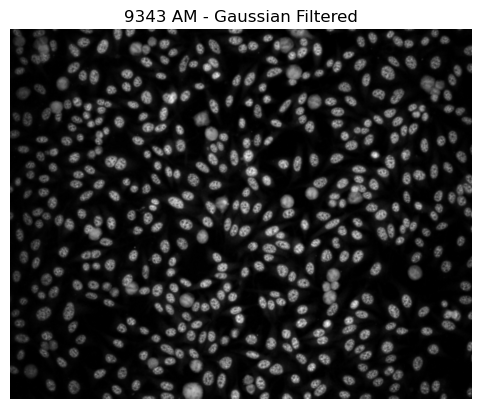

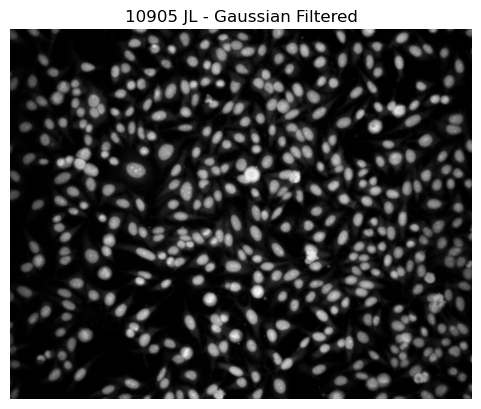

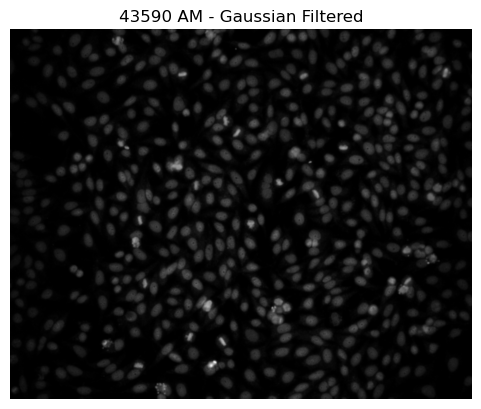

In [7]:
# List of original image after graysclaing and GAUSSIAN FILTERING
gaussian_filter_images = []
for i, image in enumerate(grayscale_images):
    gaussian_filter_images.append(remove_noise(image, gaussian_filter))
    display_single(gaussian_filter_images[i],
                   f'{image_names[i]} - Gaussian Filtered')

### Binary Ground Truth

In [8]:
def get_binary_get(image):
    # Convert to grayscale by taking the mean of the RGB channels (or use any preferred method)
    gray_ground_truth = rgb2gray(image)

    # Create binary ground truth: 1 for edxges (black pixels), 0 for non-edges (white pixels)
    binary_gt = (gray_ground_truth < 0.5).astype(int)
    display_single(binary_gt)
    return binary_gt

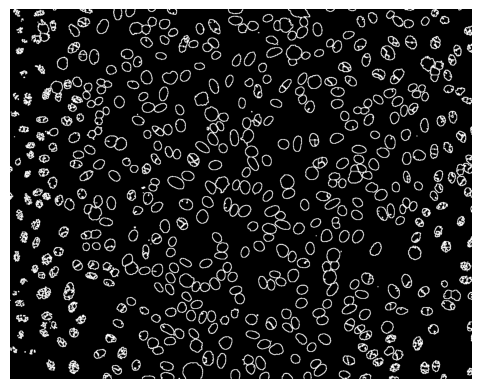

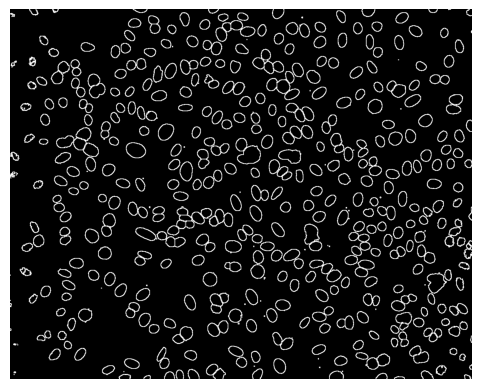

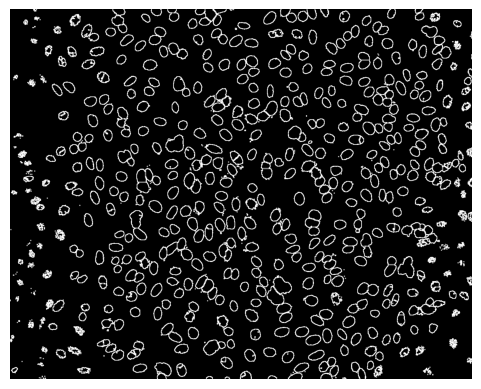

In [9]:
binary_ground_truths = []  # List for groud truth images (IN BINARY)
for gt_image in ground_truths:
    binary_ground_truths.append(get_binary_get(gt_image))

## Edge detection

In [10]:
def edge_detection(image, detector, threshold):
    # Convoling the image (X direction)
    convolve_x = scipy.signal.convolve2d(
        image, detector['x'], mode='same', boundary='symm')
    convolve_y = scipy.signal.convolve2d(
        image, detector['y'], mode='same', boundary='symm')

    # Calculating magnitude
    m = np.sqrt(np.square(convolve_x) + np.square(convolve_y))

    # Normalize
    normalized_edge = cv2.normalize(
        m, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return (normalized_edge > threshold).astype(int)

## F1 score

In [11]:
def calculate_f1_score(ground_truth, detected_edges):
    # Flatten the arrays to make them 1D for comparison
    ground_truth_flat = ground_truth.flatten()
    detected_edges_flat = detected_edges.flatten()

    # Calculate F1 score using sklearn's f1_score function
    f1_value = f1_score(ground_truth_flat, detected_edges_flat)
    return f1_value

## Image 1

In [12]:
# Dictionary (key: detector name, value: list of tuple of corresponding threshold  and F1 scores of each detector)
image1_f1 = {
    "sobel": [],
    "prewitt": [],
    "robinson": [],
    "gaussian": [],
    "kirsch": []
}
# A range of threshold values from 0 to 255 (inclusive) with a step size of 5.
thresholds = range(0, 256, 5)

# Loop through each edge detector
for detector in edge_detectors:
    # Loop through each threshold
    for threshold in thresholds:
        # Calculate edge result
        edge_result = edge_detection(
            gaussian_filter_images[0], kernels[detector], threshold)
        # Calculate F1 score for edge result and store in the dictionary as a tuple (threshold, F1)
        image1_f1[detector].append(
            (threshold, calculate_f1_score(binary_ground_truths[0], edge_result)))

In [13]:
# Dictionary to store the highest F1 score and its corresponding threshold for each detector
highest_f1_image1 = {}

for detector, scores in image1_f1.items():
    # Find the (threshold, F1score) pair with the highest F1 score and store it in dictionary
    max_threshold, max_f1 = max(scores, key=lambda x: x[1])
    highest_f1_image1[detector] = (max_threshold, max_f1)

# Print the results of highest F1 score and the threshold used for each detector
for detector, (threshold, f1) in highest_f1_image1.items():
    print(f"Highest F1 Score for {detector}: {f1} at threshold {threshold}")

Highest F1 Score for sobel: 0.5857980162308386 at threshold 75
Highest F1 Score for prewitt: 0.5866719985902032 at threshold 80
Highest F1 Score for robinson: 0.5854455156099315 at threshold 80
Highest F1 Score for gaussian: 0.5898011187703678 at threshold 85
Highest F1 Score for kirsch: 0.5844669298173363 at threshold 75


For 9343 AM 
- Detector: sobel
- Threshold: 75
- F1 score: 0.5857980162308386


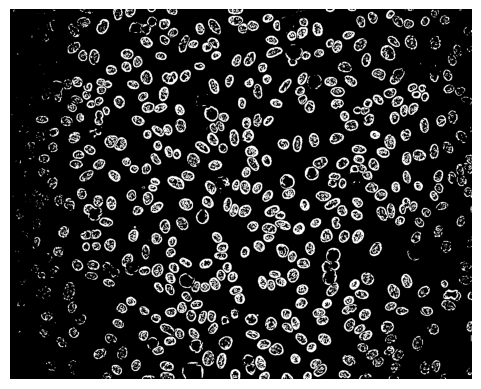

For 9343 AM 
- Detector: prewitt
- Threshold: 80
- F1 score: 0.5866719985902032


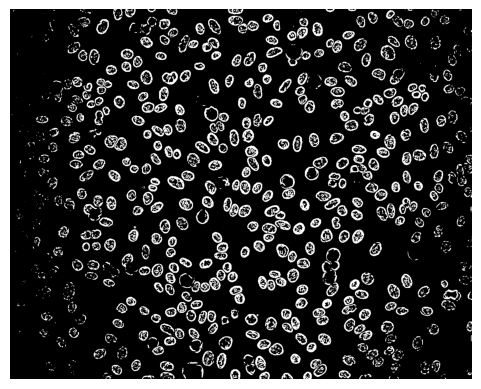

For 9343 AM 
- Detector: kirsch
- Threshold: 75
- F1 score: 0.5844669298173363


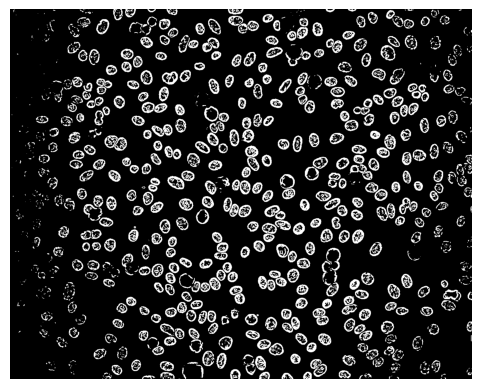

For 9343 AM 
- Detector: robinson
- Threshold: 80
- F1 score: 0.5854455156099315


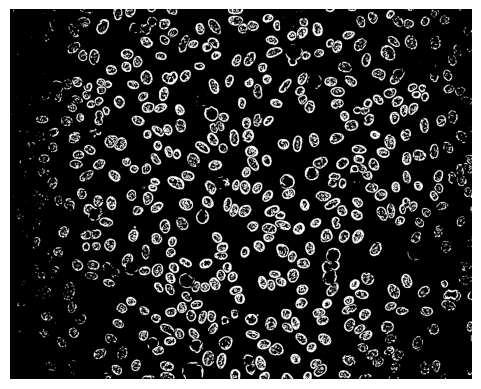

For 9343 AM 
- Detector: gaussian
- Threshold: 85
- F1 score: 0.5898011187703678


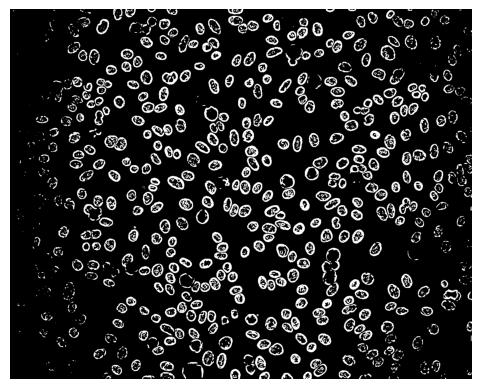

In [14]:
# Display the edge detection result and corresponding values
for detector in edge_detectors:
    print(
        f'For {image_names[0]} \n- Detector: {detector}\n- Threshold: {highest_f1_image1[detector][0]}\n- F1 score: {highest_f1_image1[detector][1]}')
    display_single(edge_detection(
        gaussian_filter_images[0], kernels[detector], highest_f1_image1[detector][0]))

## Image 2

In [15]:
# Dictionary (key: detector name, value: list of tuple of corresponding threshold  and F1 scores of each detector)
image2_f1 = {
    "sobel": [],
    "prewitt": [],
    "robinson": [],
    "gaussian": [],
    "kirsch": []
}
# A range of threshold values from 0 to 255 (inclusive) with a step size of 5.
thresholds = range(0, 256, 5)

# Loop through each edge detector
for detector in edge_detectors:
    # Loop through each threshold
    for threshold in thresholds:
        # Calculate edge result
        edge_result = edge_detection(
            gaussian_filter_images[1], kernels[detector], threshold)
        # Calculate F1 score for edge result and store in the dictionary as a tuple (threshold, F1)
        image2_f1[detector].append((threshold, calculate_f1_score(
            binary_ground_truths[1], edge_result)))

In [16]:
# Dictionary to store the highest F1 score and its corresponding threshold for each detector
highest_f1_image2 = {}

for detector, scores in image2_f1.items():
    # Find the (threshold, F1score) pair with the highest F1 score and store it in dictionary
    max_threshold, max_f1 = max(scores, key=lambda x: x[1])
    highest_f1_image2[detector] = (max_threshold, max_f1)

# Print the results of highest F1 score and the threshold used for each detector
for detector, (threshold, f1) in highest_f1_image2.items():
    print(f"Highest F1 Score for {detector}: {f1} at threshold {threshold}")

Highest F1 Score for sobel: 0.6656852506981088 at threshold 65
Highest F1 Score for prewitt: 0.6649493482411188 at threshold 65
Highest F1 Score for robinson: 0.6620632401838488 at threshold 60
Highest F1 Score for gaussian: 0.6530352064332647 at threshold 70
Highest F1 Score for kirsch: 0.6622257560488531 at threshold 65


For 10905 JL 
- Detector: sobel
- Threshold: 65
- F1 score : 0.6656852506981088


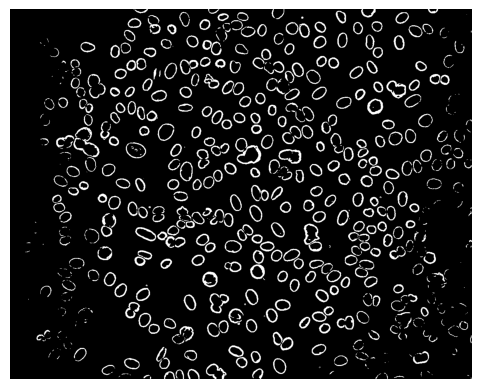

For 10905 JL 
- Detector: prewitt
- Threshold: 65
- F1 score : 0.6649493482411188


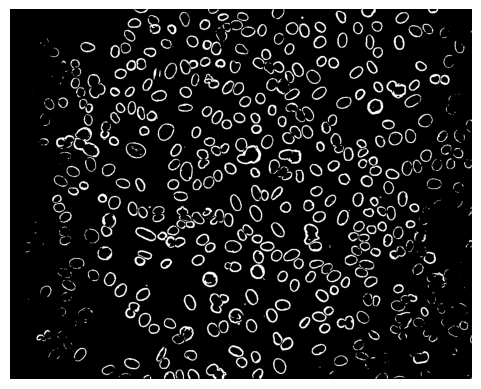

For 10905 JL 
- Detector: kirsch
- Threshold: 65
- F1 score : 0.6622257560488531


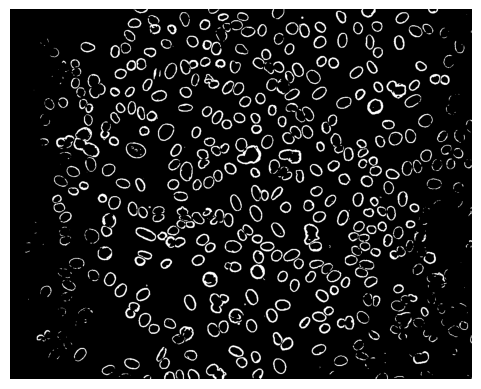

For 10905 JL 
- Detector: robinson
- Threshold: 60
- F1 score : 0.6620632401838488


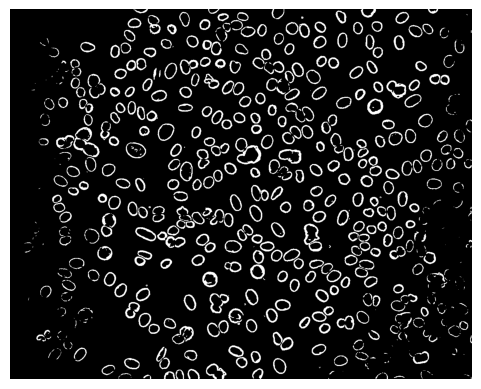

For 10905 JL 
- Detector: gaussian
- Threshold: 70
- F1 score : 0.6530352064332647


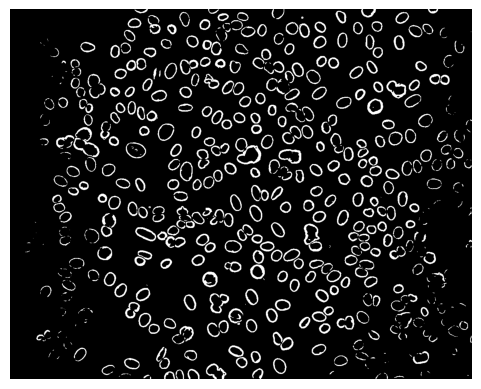

In [17]:
# Display the edge detection result and corresponding values
for detector in edge_detectors:
    print(
        f'For {image_names[1]} \n- Detector: {detector}\n- Threshold: {highest_f1_image2[detector][0]}\n- F1 score : {highest_f1_image2[detector][1]}')
    display_single(edge_detection(
        gaussian_filter_images[1], kernels[detector],  highest_f1_image2[detector][0]))

## Image3

In [18]:
# Dictionary (key: detector name, value: list of tuple of corresponding threshold  and F1 scores of each detector)
image3_f1 = {
    "sobel": [],
    "prewitt": [],
    "robinson": [],
    "gaussian": [],
    "kirsch": []
}
# A range of threshold values from 0 to 255 (inclusive) with a step size of 5.
thresholds = range(0, 256, 5)
# Loop through each edge detector
for detector in edge_detectors:
    # Loop through each threshold
    for threshold in thresholds:
        # Calculate edge result
        edge_result = edge_detection(
            gaussian_filter_images[2], kernels[detector], threshold)
        # Calculate F1 score for edge result and store in the dictionary as a tuple (threshold, F1)
        image3_f1[detector].append((threshold, calculate_f1_score(
            binary_ground_truths[2], edge_result)))

In [19]:
# Dictionary to store the highest F1 score and its corresponding threshold for each detector
highest_f1_image3 = {}

for detector, scores in image3_f1.items():
    # Find the (threshold, F1score) pair with the highest F1 score and store it in dictionary
    max_threshold, max_f1 = max(scores, key=lambda x: x[1])
    highest_f1_image3[detector] = (max_threshold, max_f1)

# Print the results of highest F1 score and the threshold used for each detector
for detector, (threshold, f1) in highest_f1_image3.items():
    print(f"Highest F1 Score for {detector}: {f1} at threshold {threshold}")

Highest F1 Score for sobel: 0.5644270923241353 at threshold 25
Highest F1 Score for prewitt: 0.5650349956734614 at threshold 25
Highest F1 Score for robinson: 0.5598373019744396 at threshold 25
Highest F1 Score for gaussian: 0.5663021426784871 at threshold 25
Highest F1 Score for kirsch: 0.5626196873518265 at threshold 25


For 43590 AM 
 - Detector: sobel
 - Threshold: 25
 - F1 score: 0.5644270923241353


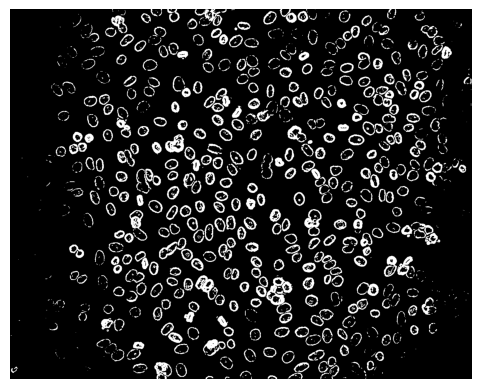

For 43590 AM 
 - Detector: prewitt
 - Threshold: 25
 - F1 score: 0.5650349956734614


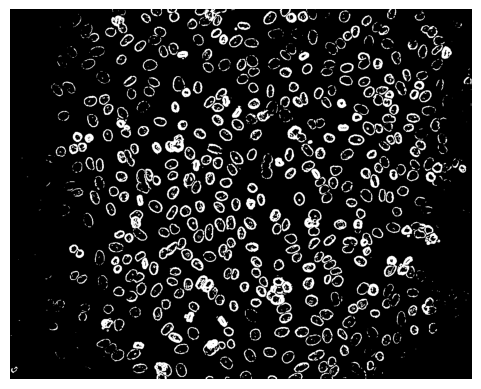

For 43590 AM 
 - Detector: kirsch
 - Threshold: 25
 - F1 score: 0.5626196873518265


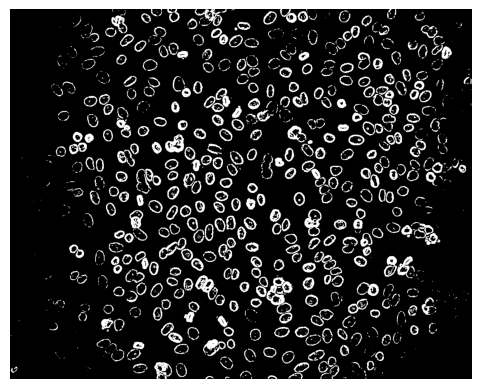

For 43590 AM 
 - Detector: robinson
 - Threshold: 25
 - F1 score: 0.5598373019744396


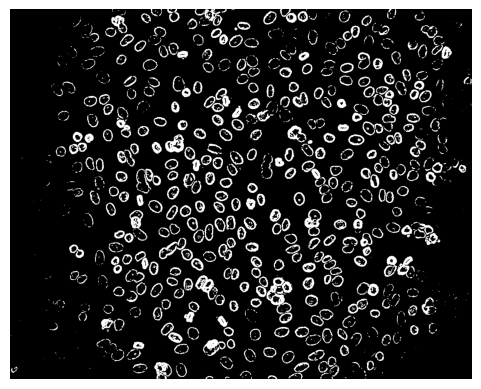

For 43590 AM 
 - Detector: gaussian
 - Threshold: 25
 - F1 score: 0.5663021426784871


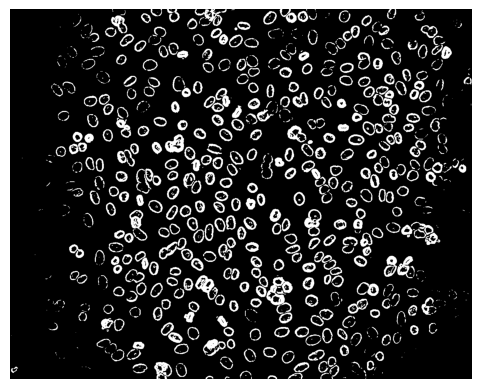

In [20]:
# Display the edge detection result and corresponding values
for detector in edge_detectors:
    print(
        f'For {image_names[2]} \n - Detector: {detector}\n - Threshold: {highest_f1_image3[detector][0]}\n - F1 score: {highest_f1_image3[detector][1]}')
    display_single(edge_detection(
        gaussian_filter_images[2], kernels[detector], highest_f1_image3[detector][0]))